## Adjusted $T_L$ experiment
---
This notebook illustrate an experiment to update $T_L$ using recurive method,

1. We will filter clear-sky days based on the rate of change (ROC). The concept is that clear-sky day data increases one way to midday then decreases the one way to the end of the day while considering roc. Another constraint is that a day will meet the criteria if and only if all clear-sky indices from all data points surpass a specific value (now using threshold_k=0.7).

2. then, we update TL using linear and huber regression with iterating method until convergence.

In [15]:
import pandas as pd
import numpy as np
from solar_utils.sky_condition_splitter import SkyConditionSplitter 
from solar_utils.clearsky_calculator import ClearskyCalculator

import warnings
warnings.filterwarnings("ignore")


In [2]:
measurement_df = pd.read_csv("example_data/sample_data.csv", parse_dates=["Datetime"])
measurement_df.replace([np.inf, -np.inf], np.NaN, inplace=True)
measurement_df.dropna(inplace = True)
measurement_df.set_index('Datetime', inplace = True)


## 1 Iteration example

In [3]:
start_TL = 4.773765928887537
site_name = "site_009"
df_site = measurement_df[measurement_df['site_name']==site_name]
lat = df_site['lat'].values[0]
long = df_site['long'].values[0]
alt = df_site['alt'].values[0]

start_date = df_site.index[0].strftime('%Y-%m-%d')
end_date = df_site.index[-1].strftime('%Y-%m-%d')


site_obj = ClearskyCalculator(lat=lat, long=long, defined_TL=start_TL)
solar_info = site_obj.get_solar_info(start_date=start_date, end_date=end_date).reset_index()

df_site = df_site.merge(solar_info, on='Datetime', how='left')
df_site['k'] = df_site['I'] / df_site['Iclr']
df_site = df_site[df_site['zna']<85]
df_site.set_index("Datetime", inplace=True)
df_site.head()




,generated_power,ambient_temp,I,py_module_temp,site_name,lat,long,alt,date,zna,AM,Iclr,cos_zna,k
Datetime,,,,,,,,,,,,,,
2022-01-01 07:30:00,55.2,30.0,105.8104,18.39167,site_009,18.1284,100.144,158,2022-01-01,82.538570,7.300772,37.890513,0.129859,2.792530
2022-01-01 07:45:00,77.6,30.0,134.8187,20.26667,site_009,18.1284,100.144,158,2022-01-01,79.391059,5.286600,79.291634,0.184105,1.700289
2022-01-01 08:00:00,132.8,29.0,204.0629,21.60833,site_009,18.1284,100.144,158,2022-01-01,76.288031,4.151729,127.135244,0.237041,1.605085
2022-01-01 08:15:00,175.2,30.0,266.5356,22.94167,site_009,18.1284,100.144,158,2022-01-01,73.235348,3.430957,177.833307,0.288441,1.498795
2022-01-01 08:30:00,214.0,31.0,324.7706,25.56667,site_009,18.1284,100.144,158,2022-01-01,70.239769,2.936379,229.353126,0.338085,1.416029


In [4]:
threshold_k=0.7
splitting_k=0.6


clr_date_list, partly_cloudy_date_list, cloudy_date_list = SkyConditionSplitter.split_day_by_ROC(df_site=df_site)
print(f'passed day of {site_name} with threshold k = {threshold_k}  {len(clr_date_list)} days')

passed day of site_009 with threshold k = 0.7  42 days


/Users/natanon.t/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


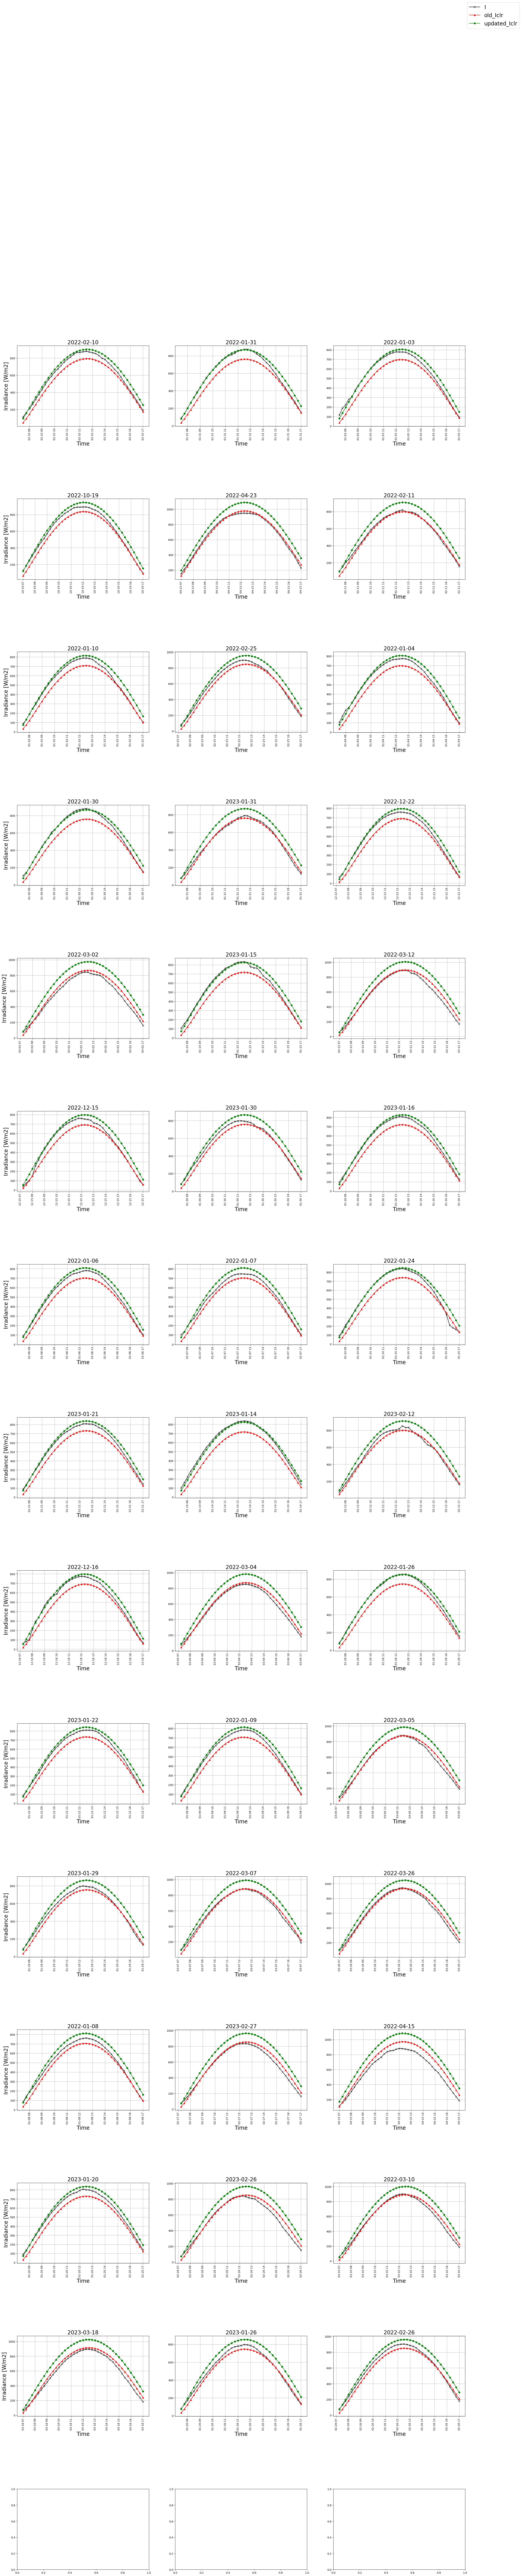

In [5]:
graph_plot = SkyConditionSplitter.plot_updated_irradiance(old_df_site=df_site, 
                                                          clr_date_list=clr_date_list, 
                                                          lat=lat, long=long, 
                                                          alt=alt,
                                                          ncols=3)


## Iteration loop

In [18]:
iteration_max = 10
site='site_009'
threshold_k=0.7
df_site = measurement_df[measurement_df['site_name'] == site]
lat = df_site['lat'].values[0]
long = df_site['long'].values[0]
alt = df_site['alt'].values[0]


start_date = df_site.index[0].strftime('%Y-%m-%d')
end_date = df_site.index[-1].strftime('%Y-%m-%d')

site_obj = ClearskyCalculator(lat=lat, long=long, defined_TL=start_TL)
solar_info = site_obj.get_solar_info(start_date=start_date, end_date=end_date).reset_index()

df_site = df_site.merge(solar_info, on='Datetime', how='left')
df_site.set_index("Datetime", inplace=True)
df_site['k'] = df_site['I'] / df_site['Iclr']
df_site = df_site[df_site['zna']<85]


print(f'{site}')
for k in range(iteration_max) :
    clr_date_list, partly_cloudy_date_list, cloudy_date_list = SkyConditionSplitter.split_day_by_ROC(df_site=df_site)
    clr_data_df = df_site[np.isin(df_site.index.date, clr_date_list)]
    TL_linear, TL_huber = SkyConditionSplitter.cal_new_TL(clr_data_df, alt=alt, huber_epsilon=1)
    df_site = SkyConditionSplitter.update_new_clr(df_site, lat, long, new_TL=TL_huber)
    print(f'iteration {k+1} has {len(clr_date_list)} clear-sky days with TL_linear = {TL_linear[0]}, TL_huber = {TL_huber}')

site_009
iteration 1 has 42 clear-sky days with TL_linear = 2.051390856243483, TL_huber = 2.0915644396080797
iteration 2 has 6 clear-sky days with TL_linear = 1.716277530804093, TL_huber = 1.7072337703495588
iteration 3 has 3 clear-sky days with TL_linear = 1.6630108824756529, TL_huber = 1.622946511552834
iteration 4 has 3 clear-sky days with TL_linear = 1.6630108824756529, TL_huber = 1.622946511552834
iteration 5 has 3 clear-sky days with TL_linear = 1.6630108824756529, TL_huber = 1.622946511552834
iteration 6 has 3 clear-sky days with TL_linear = 1.6630108824756529, TL_huber = 1.622946511552834
iteration 7 has 3 clear-sky days with TL_linear = 1.6630108824756529, TL_huber = 1.622946511552834
iteration 8 has 3 clear-sky days with TL_linear = 1.6630108824756529, TL_huber = 1.622946511552834
iteration 9 has 3 clear-sky days with TL_linear = 1.6630108824756529, TL_huber = 1.622946511552834
iteration 10 has 3 clear-sky days with TL_linear = 1.6630108824756529, TL_huber = 1.622946511552834